In [1]:
import requests
from io import StringIO
import json
from datetime import datetime

import pandas as pd
import numpy as np
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point

import matplotlib.pyplot as plt
from IPython.display import Image

import folium
from folium.plugins import MarkerCluster
from folium.plugins import FastMarkerCluster

from io import StringIO
import statsmodels.api as sm
from statsmodels.formula.api import glm

%matplotlib inline

with open('../data/burglary.json') as fi:
    credentials = json.load(fi)
    
api_key = credentials['api_key']

1. A dataset containing details about Metro Nashville Police Department reported incidents is available at https://data.nashville.gov/Police/Metro-Nashville-Police-Department-Incidents/2u6v-ujjs. Make use of the API to find all aggravated burglary incidents that were reported during the six month period from January 1, 2021 through June 30, 2021.

In [2]:
#reading aggravated burglary data between January 1-June 30, 2021
burglary_endpoint = 'https://data.nashville.gov/resource/2u6v-ujjs.json'
params = {
    'offense_description': 'BURGLARY- AGGRAVATED',
    '$where': 'incident_reported between \'2021-01-01T00:00:00\' and \'2021-06-30T23:59:59\'',
    '$limit': 50000
}

In [3]:
burglary_response = requests.get(burglary_endpoint, 
                        params = params)
burglary_response

<Response [200]>

In [4]:
res = burglary_response.json()
res

[{'primary_key': '20210249540_11',
  'incident_number': '20210249540',
  'report_type': 'D',
  'report_type_description': 'DISPATCHED',
  'incident_status_code': 'O',
  'incident_status_description': 'OPEN',
  'investigation_status': 'Open',
  'incident_occurred': '2021-05-04T23:45:00.000',
  'incident_reported': '2021-05-05T00:45:00.000',
  'incident_location': 'UNIVERSITY CT',
  'latitude': '36.15',
  'longitude': '-86.77',
  'rpa': '8203',
  'zone': '511',
  'location_code': '22',
  'location_description': 'RESIDENCE, HOME',
  'offense_number': '1',
  'offense_nibrs': '220',
  'offense_description': 'BURGLARY- AGGRAVATED',
  'weapon_primary': '09',
  'weapon_description': 'PERSONAL (HANDS)',
  'victim_number': '1',
  'domestic_related': False,
  'victim_type': 'I',
  'victim_description': 'INDIVIDUAL (18 AND OVER)',
  'victim_gender': 'F',
  'victim_race': 'B',
  'victim_ethnicity': 'Non-Hispanic',
  'victim_county_resident': 'RESIDENT',
  'mapped_location': {'type': 'Point', 'coord

In [5]:
type(res)

list

In [6]:
#creating a dataframe from a list 
burglary_incident= pd.DataFrame.from_dict(res)
burglary_incident.head(3)

,primary_key,incident_number,report_type,report_type_description,incident_status_code,incident_status_description,investigation_status,incident_occurred,incident_reported,incident_location,...,victim_number,domestic_related,victim_type,victim_description,victim_gender,victim_race,victim_ethnicity,victim_county_resident,mapped_location,zip_code
0,20210249540_11,20210249540,D,DISPATCHED,O,OPEN,Open,2021-05-04T23:45:00.000,2021-05-05T00:45:00.000,UNIVERSITY CT,...,1,False,I,INDIVIDUAL (18 AND OVER),F,B,Non-Hispanic,RESIDENT,"{'type': 'Point', 'coordinates': [-86.77, 36.15]}",NaN
1,20210248840_11,20210248840,D,DISPATCHED,O,OPEN,Open,2021-05-04T12:06:00.000,2021-05-04T14:33:00.000,BONNAFAIR DR,...,1,False,I,INDIVIDUAL (18 AND OVER),F,W,Non-Hispanic,RESIDENT,"{'type': 'Point', 'coordinates': [-86.63, 36.2]}",NaN
2,20210244919_11,20210244919,D,DISPATCHED,O,OPEN,Open,2021-05-01T23:00:00.000,2021-05-02T12:40:00.000,8TH AVE S,...,1,False,I,INDIVIDUAL (18 AND OVER),M,W,Non-Hispanic,NON RESIDENT,"{'type': 'Point', 'coordinates': [-86.78, 36.14]}",NaN


In [63]:
#drop duplicate incidents
burglary_incident=burglary_incident.drop_duplicates(subset='incident_number')

In [8]:
burglary_incident.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 828 entries, 0 to 1050
Data columns (total 31 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   primary_key                  828 non-null    object
 1   incident_number              828 non-null    object
 2   report_type                  828 non-null    object
 3   report_type_description      816 non-null    object
 4   incident_status_code         828 non-null    object
 5   incident_status_description  828 non-null    object
 6   investigation_status         828 non-null    object
 7   incident_occurred            828 non-null    object
 8   incident_reported            828 non-null    object
 9   incident_location            826 non-null    object
 10  latitude                     826 non-null    object
 11  longitude                    826 non-null    object
 12  rpa                          771 non-null    object
 13  zone                         771 n

In [9]:
burglary_incident['offense_description'].unique()

array(['BURGLARY- AGGRAVATED'], dtype=object)

In [10]:
#total number of incidents 
burglary_incident['incident_number'].value_counts().sum()

828

In [11]:
#checking the number of burglary aggravated
burglary_incident.set_index('offense_description').loc['BURGLARY- AGGRAVATED'].count()

primary_key                    828
incident_number                828
report_type                    828
report_type_description        816
incident_status_code           828
incident_status_description    828
investigation_status           828
incident_occurred              828
incident_reported              828
incident_location              826
latitude                       826
longitude                      826
rpa                            771
zone                           771
location_code                  828
location_description           828
offense_number                 828
offense_nibrs                  828
weapon_primary                 828
weapon_description             828
victim_number                  828
domestic_related               828
victim_type                    828
victim_description             827
victim_gender                  803
victim_race                    803
victim_ethnicity               803
victim_county_resident         803
mapped_location     

In [12]:
burglary_incident.columns

Index(['primary_key', 'incident_number', 'report_type',
       'report_type_description', 'incident_status_code',
       'incident_status_description', 'investigation_status',
       'incident_occurred', 'incident_reported', 'incident_location',
       'latitude', 'longitude', 'rpa', 'zone', 'location_code',
       'location_description', 'offense_number', 'offense_nibrs',
       'offense_description', 'weapon_primary', 'weapon_description',
       'victim_number', 'domestic_related', 'victim_type',
       'victim_description', 'victim_gender', 'victim_race',
       'victim_ethnicity', 'victim_county_resident', 'mapped_location',
       'zip_code'],
      dtype='object')

In [13]:
#changing the data type
burglary_incident = burglary_incident.astype({
    'incident_occurred': 'datetime64',
    'incident_reported': 'datetime64',
    'incident_number' : 'int64',
    'latitude': 'float64',
    'longitude': 'float64'
})

In [14]:
burglary_incident.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 828 entries, 0 to 1050
Data columns (total 31 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   primary_key                  828 non-null    object        
 1   incident_number              828 non-null    int64         
 2   report_type                  828 non-null    object        
 3   report_type_description      816 non-null    object        
 4   incident_status_code         828 non-null    object        
 5   incident_status_description  828 non-null    object        
 6   investigation_status         828 non-null    object        
 7   incident_occurred            828 non-null    datetime64[ns]
 8   incident_reported            828 non-null    datetime64[ns]
 9   incident_location            826 non-null    object        
 10  latitude                     826 non-null    float64       
 11  longitude                    826 non-null   

In [96]:
#dropping nulls in 'lat' and 'long' columns
burglary_incident= burglary_incident.dropna(subset = ['latitude','longitude'])

In [97]:
#adding geometry column
burglary_incident['geometry'] = burglary_incident.apply(lambda x: Point((x.longitude, 
                                                                         x.latitude)), 
                                                        axis=1)
#burglary_incident.head(3)

In [98]:
#creating a geo data frame
burglary_incident_geo = gpd.GeoDataFrame(burglary_incident, 
                           geometry = burglary_incident['geometry'])

In [99]:
#changing the crs to 4326
burglary_incident_geo = burglary_incident_geo.set_crs(4326, allow_override=True)

In [19]:
#burglary_incident_geo.crs

2. Download the 2019 census tract shapefiles for Tennessee from https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.2019.html. (The FIPS code for Tennessee is 47). Perform a spatial join to determine the census tract in which each burglary incident occurred. Which census tract had the highest number of burglaries? Warning - each incident can appear multiple times if there are multiple victims, so be sure that you aren't double-counting any incidents.

In [20]:
census_tract= gpd.read_file('../data/tl_2019_47_tract/tl_2019_47_tract.shp')
census_tract.head(3)

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,47,165,021002,47165021002,210.02,Census Tract 210.02,G5020,S,30654374,207994,+36.3521602,-086.6464309,"POLYGON ((-86.69927 36.32775, -86.69923 36.327..."
1,47,165,020901,47165020901,209.01,Census Tract 209.01,G5020,S,23811766,3412697,+36.3483143,-086.4070907,"POLYGON ((-86.43949 36.35962, -86.43915 36.359..."
2,47,165,020300,47165020300,203,Census Tract 203,G5020,S,14629292,0,+36.5796910,-086.5114955,"POLYGON ((-86.53716 36.56852, -86.53713 36.568..."


In [21]:
census_tract = census_tract.set_crs(4326, allow_override=True)
print(census_tract.crs)

epsg:4326


In [22]:
census_tract.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1497 entries, 0 to 1496
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   STATEFP   1497 non-null   object  
 1   COUNTYFP  1497 non-null   object  
 2   TRACTCE   1497 non-null   object  
 3   GEOID     1497 non-null   object  
 4   NAME      1497 non-null   object  
 5   NAMELSAD  1497 non-null   object  
 6   MTFCC     1497 non-null   object  
 7   FUNCSTAT  1497 non-null   object  
 8   ALAND     1497 non-null   int64   
 9   AWATER    1497 non-null   int64   
 10  INTPTLAT  1497 non-null   object  
 11  INTPTLON  1497 non-null   object  
 12  geometry  1497 non-null   geometry
dtypes: geometry(1), int64(2), object(10)
memory usage: 152.2+ KB


In [23]:
#spatial join between burglary and censys tract data 
incidents_by_tract = gpd.sjoin(census_tract, burglary_incident_geo)
incidents_by_tract.head(3)

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,...,victim_number,domestic_related,victim_type,victim_description,victim_gender,victim_race,victim_ethnicity,victim_county_resident,mapped_location,zip_code
27,47,037,010106,47037010106,101.06,Census Tract 101.06,G5020,S,21505677,6845,...,1,False,B,BUSINESS,NaN,NaN,NaN,NaN,"{'type': 'Point', 'coordinates': [-86.78, 36.25]}",NaN
27,47,037,010106,47037010106,101.06,Census Tract 101.06,G5020,S,21505677,6845,...,1,False,B,BUSINESS,NaN,NaN,NaN,NaN,"{'type': 'Point', 'coordinates': [-86.78, 36.25]}",NaN
27,47,037,010106,47037010106,101.06,Census Tract 101.06,G5020,S,21505677,6845,...,1,False,I,INDIVIDUAL (18 AND OVER),F,U,Non-Hispanic,RESIDENT,"{'type': 'Point', 'coordinates': [-86.78, 36.25]}",NaN


In [24]:
incidents_by_tract.columns

Index(['STATEFP', 'COUNTYFP', 'TRACTCE', 'GEOID', 'NAME', 'NAMELSAD', 'MTFCC',
       'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON', 'geometry',
       'index_right', 'primary_key', 'incident_number', 'report_type',
       'report_type_description', 'incident_status_code',
       'incident_status_description', 'investigation_status',
       'incident_occurred', 'incident_reported', 'incident_location',
       'latitude', 'longitude', 'rpa', 'zone', 'location_code',
       'location_description', 'offense_number', 'offense_nibrs',
       'offense_description', 'weapon_primary', 'weapon_description',
       'victim_number', 'domestic_related', 'victim_type',
       'victim_description', 'victim_gender', 'victim_race',
       'victim_ethnicity', 'victim_county_resident', 'mapped_location',
       'zip_code'],
      dtype='object')

In [25]:
#The number of burglaries in each census tract
numbers=pd.DataFrame(incidents_by_tract['NAMELSAD'].value_counts())
numbers

,NAMELSAD
Census Tract 163,53
Census Tract 162,21
Census Tract 110.01,20
Census Tract 195,19
Census Tract 193,19
...,...
Census Tract 188.01,1
Census Tract 136.02,1
Census Tract 103.03,1
Census Tract 156.19,1


In [26]:
#incidents_by_tract ['numbers']= pd.DataFrame(incidents_by_tract['NAMELSAD'].value_counts())

In [27]:
#another way of showing the number of burglaries 
display(incidents_by_tract.groupby('TRACTCE')['incident_number'].nunique().nlargest(5))

TRACTCE
016300    53
016200    21
011001    20
019300    19
019500    19
Name: incident_number, dtype: int64

3. For this part, you'll need to request a census API key. Using the 2019 American Community Survey API, obtain, for each census tract, the population (B01001_001E in the detailed tables) and the median income (S1901_C01_012E in the subject tables). Hint: Tennessee's FIPS code is 47 and Davidson County's FIPS code is 37. Merge this new data with the burglaries data above.



In [28]:
#read in API ket for census 
with open("../data/census.json") as fi:
        credentials = json.load(fi)

api_key = credentials["api_key"]

In [29]:
#read in population data from census website 
census_endpoint='https://api.census.gov/data/2019/acs/acs5'
census_params= {
      'get': 'B01001_001E',
       'for': 'tract:*',
       'in': 'state:47 county:037',
       'key': api_key
}

In [30]:
census_response=requests.get(census_endpoint, params=census_params)
census_response

<Response [200]>

In [31]:
response= census_response.json()
response

[['B01001_001E', 'state', 'county', 'tract'],
 ['12176', '47', '037', '015631'],
 ['4098', '47', '037', '015804'],
 ['2466', '47', '037', '017701'],
 ['5210', '47', '037', '017702'],
 ['8254', '47', '037', '018301'],
 ['2774', '47', '037', '018302'],
 ['4205', '47', '037', '018409'],
 ['3467', '47', '037', '018410'],
 ['2553', '47', '037', '011002'],
 ['1860', '47', '037', '014300'],
 ['4717', '47', '037', '015402'],
 ['4882', '47', '037', '015405'],
 ['3820', '47', '037', '015502'],
 ['5553', '47', '037', '015615'],
 ['6507', '47', '037', '015618'],
 ['4841', '47', '037', '016500'],
 ['4849', '47', '037', '016800'],
 ['5386', '47', '037', '017402'],
 ['2967', '47', '037', '017500'],
 ['3619', '47', '037', '018102'],
 ['7432', '47', '037', '018401'],
 ['4187', '47', '037', '018602'],
 ['4519', '47', '037', '019003'],
 ['2205', '47', '037', '012600'],
 ['5240', '47', '037', '010501'],
 ['3397', '47', '037', '010106'],
 ['2533', '47', '037', '010103'],
 ['2955', '47', '037', '010104'],
 

In [32]:
#creating a dataframe from the list 
population=pd.DataFrame(response, columns= ['population','state', 'county', 'tract']).drop(labels=0, axis=0)
population

,population,state,county,tract
1,12176,47,037,015631
2,4098,47,037,015804
3,2466,47,037,017701
4,5210,47,037,017702
5,8254,47,037,018301
...,...,...,...,...
157,5252,47,037,015613
158,7262,47,037,015620
159,2345,47,037,016100
160,4617,47,037,011400


In [33]:
#population = population.rename(columns={'B01001_001E': 'population'}) #can also use this code to change names of columns

In [34]:
#changing population type 
population['population'] = population['population'].astype(int)

In [35]:
#read in median income data from census website 
subject_endpoint = 'https://api.census.gov/data/2019/acs/acs5/subject'
subject_params = {
    'get': 'S1901_C01_012E',
    'for': 'tract:*',
    'in': 'state:47 county:037',
    'key': api_key
}
subject_response = requests.get(subject_endpoint, params = subject_params)

In [36]:
subject_response

<Response [200]>

In [37]:
median = subject_response.json()
median

[['S1901_C01_012E', 'state', 'county', 'tract'],
 ['75579', '47', '037', '015631'],
 ['45129', '47', '037', '015804'],
 ['134786', '47', '037', '017701'],
 ['107813', '47', '037', '017702'],
 ['87591', '47', '037', '018301'],
 ['96576', '47', '037', '018302'],
 ['65887', '47', '037', '018409'],
 ['58028', '47', '037', '018410'],
 ['49926', '47', '037', '011002'],
 ['35313', '47', '037', '014300'],
 ['69740', '47', '037', '015402'],
 ['62143', '47', '037', '015405'],
 ['46786', '47', '037', '015502'],
 ['45552', '47', '037', '015615'],
 ['53969', '47', '037', '015618'],
 ['54491', '47', '037', '016500'],
 ['58810', '47', '037', '016800'],
 ['41354', '47', '037', '017402'],
 ['36283', '47', '037', '017500'],
 ['81724', '47', '037', '018102'],
 ['60518', '47', '037', '018401'],
 ['188375', '47', '037', '018602'],
 ['47906', '47', '037', '019003'],
 ['50764', '47', '037', '012600'],
 ['60990', '47', '037', '010501'],
 ['63864', '47', '037', '010106'],
 ['70341', '47', '037', '010103'],
 ['

In [38]:
#creating a dataframe from the list 
income=pd.DataFrame(median, columns= ['median_income','state', 'county', 'tract']).drop(labels=0, axis=0)
income

,median_income,state,county,tract
1,75579,47,037,015631
2,45129,47,037,015804
3,134786,47,037,017701
4,107813,47,037,017702
5,87591,47,037,018301
...,...,...,...,...
157,37656,47,037,015613
158,54149,47,037,015620
159,48221,47,037,016100
160,50857,47,037,011400


In [39]:
#changing median income type
income['median_income']=income['median_income'].astype(int)

In [40]:
income.head()

,median_income,state,county,tract
1,75579,47,037,015631
2,45129,47,037,015804
3,134786,47,037,017701
4,107813,47,037,017702
5,87591,47,037,018301


In [41]:
income.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 161 entries, 1 to 161
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   median_income  161 non-null    int64 
 1   state          161 non-null    object
 2   county         161 non-null    object
 3   tract          161 non-null    object
dtypes: int64(1), object(3)
memory usage: 6.3+ KB


In [42]:
#merging population data with median income 
pop_income=population.merge(income, on= 'tract').drop(columns= ['state_y','state_x', 'county_x', 'county_y'])
pop_income

,population,tract,median_income
0,12176,015631,75579
1,4098,015804,45129
2,2466,017701,134786
3,5210,017702,107813
4,8254,018301,87591
...,...,...,...
156,5252,015613,37656
157,7262,015620,54149
158,2345,016100,48221
159,4617,011400,50857


In [64]:
#merging the above data set with the burglary
burglary_incidents=pop_income.merge(incidents_by_tract.rename (columns= {'TRACTCE':'tract'}))
burglary_incidents

,population,tract,median_income,STATEFP,COUNTYFP,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,...,victim_number,domestic_related,victim_type,victim_description,victim_gender,victim_race,victim_ethnicity,victim_county_resident,mapped_location,zip_code
0,12176,015631,75579,47,037,47037015631,156.31,Census Tract 156.31,G5020,S,...,1,False,I,INDIVIDUAL (18 AND OVER),F,B,Non-Hispanic,RESIDENT,"{'type': 'Point', 'coordinates': [-86.58, 36.03]}",NaN
1,12176,015631,75579,47,037,47037015631,156.31,Census Tract 156.31,G5020,S,...,1,False,I,INDIVIDUAL (18 AND OVER),F,W,Hispanic,RESIDENT,"{'type': 'Point', 'coordinates': [-86.58, 36.03]}",NaN
2,12176,015631,75579,47,037,47037015631,156.31,Census Tract 156.31,G5020,S,...,1,False,I,INDIVIDUAL (18 AND OVER),M,W,Hispanic,RESIDENT,"{'type': 'Point', 'coordinates': [-86.61, 36.05]}",NaN
3,12176,015631,75579,47,037,47037015631,156.31,Census Tract 156.31,G5020,S,...,1,False,I,INDIVIDUAL (18 AND OVER),M,W,Unknown,UNKNOWN,"{'type': 'Point', 'coordinates': [-86.58, 36.05]}",NaN
4,12176,015631,75579,47,037,47037015631,156.31,Census Tract 156.31,G5020,S,...,1,False,I,INDIVIDUAL (18 AND OVER),F,A,Non-Hispanic,RESIDENT,"{'type': 'Point', 'coordinates': [-86.59, 36.05]}",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
821,4617,011400,50857,47,037,47037011400,114,Census Tract 114,G5020,S,...,1,False,I,INDIVIDUAL (18 AND OVER),F,B,Non-Hispanic,NON RESIDENT,"{'type': 'Point', 'coordinates': [-86.727, 36....",37206
822,2099,013800,37679,47,037,47037013800,138,Census Tract 138,G5020,S,...,1,True,I,INDIVIDUAL (18 AND OVER),M,B,Non-Hispanic,RESIDENT,"{'type': 'Point', 'coordinates': [-86.81, 36.17]}",NaN
823,2099,013800,37679,47,037,47037013800,138,Census Tract 138,G5020,S,...,1,False,I,INDIVIDUAL (18 AND OVER),F,B,Non-Hispanic,RESIDENT,"{'type': 'Point', 'coordinates': [-86.81, 36.17]}",NaN
824,2099,013800,37679,47,037,47037013800,138,Census Tract 138,G5020,S,...,1,False,I,INDIVIDUAL (18 AND OVER),M,W,Unknown,UNKNOWN,"{'type': 'Point', 'coordinates': [-86.81, 36.17]}",NaN


In [65]:
#countine number of incidents in each census tract 
by_tract=pd.DataFrame(incidents_by_tract ['TRACTCE'].value_counts()) 
by_tract

,TRACTCE
016300,53
016200,21
011001,20
019500,19
019300,19
...,...
013202,1
015619,1
015501,1
017901,1


In [66]:
#merging by_tract above with our data set burglary_incidents 
burglary_agg = (by_tract.
               merge(burglary_incidents,
               left_index = True,
                right_on = 'tract')
               .rename (columns= {'TRACTCE': 'burglary_number'}) 
             .astype(dtype = {'population': 'int64'}))
burglary_agg

,burglary_number,population,tract,median_income,STATEFP,COUNTYFP,GEOID,NAME,NAMELSAD,MTFCC,...,victim_number,domestic_related,victim_type,victim_description,victim_gender,victim_race,victim_ethnicity,victim_county_resident,mapped_location,zip_code
359,53,2560,016300,50710,47,037,47037016300,163,Census Tract 163,G5020,...,1,False,R,RELIGIOUS,NaN,NaN,NaN,NaN,"{'type': 'Point', 'coordinates': [-86.79, 36.15]}",NaN
360,53,2560,016300,50710,47,037,47037016300,163,Census Tract 163,G5020,...,6,False,I,INDIVIDUAL (18 AND OVER),M,W,Non-Hispanic,NON RESIDENT,"{'type': 'Point', 'coordinates': [-86.79, 36.15]}",NaN
361,53,2560,016300,50710,47,037,47037016300,163,Census Tract 163,G5020,...,1,False,I,INDIVIDUAL (18 AND OVER),M,W,Non-Hispanic,NON RESIDENT,"{'type': 'Point', 'coordinates': [-86.79, 36.15]}",NaN
362,53,2560,016300,50710,47,037,47037016300,163,Census Tract 163,G5020,...,3,False,I,INDIVIDUAL (18 AND OVER),F,W,Non-Hispanic,NON RESIDENT,"{'type': 'Point', 'coordinates': [-86.79, 36.15]}",NaN
363,53,2560,016300,50710,47,037,47037016300,163,Census Tract 163,G5020,...,1,False,I,INDIVIDUAL (18 AND OVER),F,W,Non-Hispanic,RESIDENT,"{'type': 'Point', 'coordinates': [-86.79, 36.15]}",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,1,3330,013202,64583,47,037,47037013202,132.02,Census Tract 132.02,G5020,...,1,False,I,INDIVIDUAL (18 AND OVER),M,W,Non-Hispanic,RESIDENT,"{'type': 'Point', 'coordinates': [-86.88, 36.16]}",NaN
614,1,5105,015619,74335,47,037,47037015619,156.19,Census Tract 156.19,G5020,...,1,False,I,INDIVIDUAL (18 AND OVER),F,W,Non-Hispanic,RESIDENT,"{'type': 'Point', 'coordinates': [-86.603, 36....",37013
747,1,3190,015501,56075,47,037,47037015501,155.01,Census Tract 155.01,G5020,...,1,False,I,INDIVIDUAL (18 AND OVER),M,B,Non-Hispanic,RESIDENT,"{'type': 'Point', 'coordinates': [-86.626, 36....",37214
461,1,4900,017901,98843,47,037,47037017901,179.01,Census Tract 179.01,G5020,...,1,False,I,INDIVIDUAL (18 AND OVER),F,W,Non-Hispanic,RESIDENT,"{'type': 'Point', 'coordinates': [-86.83, 36.11]}",NaN


In [67]:
burglary_agg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 826 entries, 359 to 611
Data columns (total 48 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   burglary_number              826 non-null    int64         
 1   population                   826 non-null    int64         
 2   tract                        826 non-null    object        
 3   median_income                826 non-null    int64         
 4   STATEFP                      826 non-null    object        
 5   COUNTYFP                     826 non-null    object        
 6   GEOID                        826 non-null    object        
 7   NAME                         826 non-null    object        
 8   NAMELSAD                     826 non-null    object        
 9   MTFCC                        826 non-null    object        
 10  FUNCSTAT                     826 non-null    object        
 11  ALAND                        826 non-null  

In [68]:
#checking to see if we have less than 0 for population and median income 
print(burglary_agg[burglary_agg['population'] <= 0])
print('-----------------------------')
print(burglary_agg[burglary_agg['median_income'] <= 0])

     burglary_number  population   tract  median_income STATEFP COUNTYFP  \
350                3           0  980100     -666666666      47      037   
351                3           0  980100     -666666666      47      037   
352                3           0  980100     -666666666      47      037   

           GEOID  NAME           NAMELSAD  MTFCC  ... victim_number  \
350  47037980100  9801  Census Tract 9801  G5020  ...             1   
351  47037980100  9801  Census Tract 9801  G5020  ...             1   
352  47037980100  9801  Census Tract 9801  G5020  ...             2   

     domestic_related  victim_type        victim_description victim_gender  \
350             False            I  INDIVIDUAL (18 AND OVER)             F   
351             False            I  INDIVIDUAL (18 AND OVER)             F   
352             False            I  INDIVIDUAL (18 AND OVER)             M   

    victim_race  victim_ethnicity victim_county_resident  \
350           B      Non-Hispanic    

In [69]:
#dropping rows with non-positive median income and population
burglary_agg = burglary_agg.drop(index=[350, 351, 352,155])

In [70]:
#creating column with burglaries per 1000 residents 
burglary_agg['burglaries_per_1000'] = burglary_agg['burglary_number'] / (burglary_agg['population'] / 1000)


In [50]:
#creating a geo data frame 
burglary_agg_geo = gpd.GeoDataFrame(burglary_agg,
                                geometry = burglary_agg['geometry'])
burglary_agg_geo.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 822 entries, 359 to 611
Data columns (total 49 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   burglary_number              822 non-null    int64         
 1   population                   822 non-null    int64         
 2   tract                        822 non-null    object        
 3   median_income                822 non-null    int64         
 4   STATEFP                      822 non-null    object        
 5   COUNTYFP                     822 non-null    object        
 6   GEOID                        822 non-null    object        
 7   NAME                         822 non-null    object        
 8   NAMELSAD                     822 non-null    object        
 9   MTFCC                        822 non-null    object        
 10  FUNCSTAT                     822 non-null    object        
 11  ALAND                        822 no

4. Create a choropleth showing the number of burglaries per 1000 residents for each census tract.

In [102]:
burglary_agg_geo=burglary_agg_geo.drop_duplicates(subset= 'tract')

In [104]:
burglary_agg_geo=burglary_agg_geo.drop_duplicates(subset= 'incident_number')

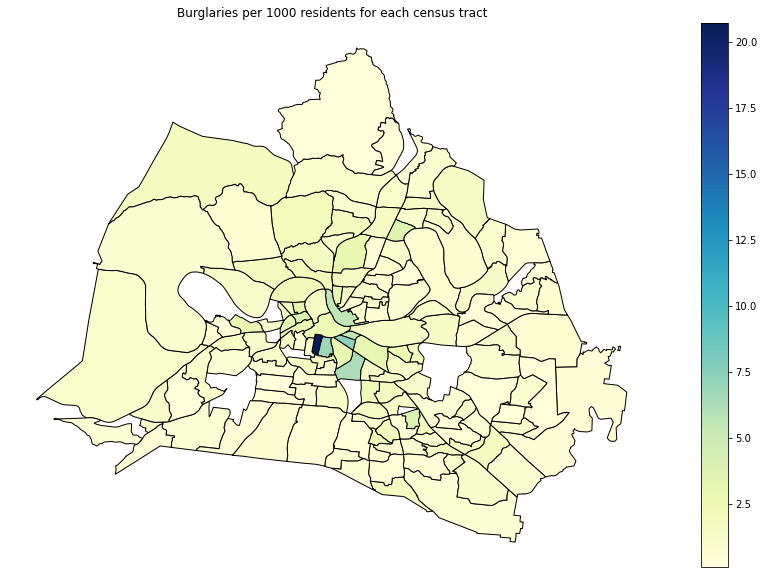

In [105]:
#choropleth for burglary per 1000 residents 
fig, ax = plt.subplots(figsize=(16,10))
burglaries=burglary_agg_geo.plot(column = 'burglaries_per_1000',
               cmap = 'YlGnBu', 
               edgecolor = 'black',
               legend = True, 
               ax = ax)
ax.axis('off')
plt.title('Burglaries per 1000 residents for each census tract', fontsize = 12);

In [106]:
burglary_agg_geo.geometry.centroid

359    POINT (-86.78991 36.14319)
751    POINT (-86.78199 36.13994)
551    POINT (-86.75983 36.22296)
326    POINT (-86.78168 36.15764)
298    POINT (-86.76887 36.17114)
                  ...            
140    POINT (-86.87151 36.15831)
614    POINT (-86.59070 36.09721)
747    POINT (-86.64442 36.17094)
461    POINT (-86.82680 36.10825)
611    POINT (-86.73641 36.17015)
Length: 146, dtype: geometry

In [110]:
center = burglary_agg_geo.geometry.centroid
print(center)

359    POINT (-86.78991 36.14319)
751    POINT (-86.78199 36.13994)
551    POINT (-86.75983 36.22296)
326    POINT (-86.78168 36.15764)
298    POINT (-86.76887 36.17114)
                  ...            
140    POINT (-86.87151 36.15831)
614    POINT (-86.59070 36.09721)
747    POINT (-86.64442 36.17094)
461    POINT (-86.82680 36.10825)
611    POINT (-86.73641 36.17015)
Length: 146, dtype: geometry


In [135]:
area_center = [center.y, center.x]
print(area_center)

[359    36.143191
751    36.139941
551    36.222963
326    36.157644
298    36.171144
         ...    
140    36.158309
614    36.097211
747    36.170937
461    36.108252
611    36.170149
Length: 146, dtype: float64, 359   -86.789913
751   -86.781992
551   -86.759829
326   -86.781679
298   -86.768865
         ...    
140   -86.871505
614   -86.590702
747   -86.644422
461   -86.826804
611   -86.736411
Length: 146, dtype: float64]


In [112]:
burglary_map= burglary_agg_geo.drop(columns=['incident_occurred', 'incident_reported'], axis=1) 

In [93]:
burglary_agg_geo=burglary_agg_geo.drop_duplicates(subset= 'tract')

In [138]:
map_street = folium.Map(location = [36.1627, -86.7816], 
                  min_zoom = 10)
display (map_street)

In [118]:
burglary_agg_geo.crs = "EPSG:4326"

In [143]:
burglary_agg_geo.head()

,burglary_number,population,tract,median_income,STATEFP,COUNTYFP,GEOID,NAME,NAMELSAD,MTFCC,...,domestic_related,victim_type,victim_description,victim_gender,victim_race,victim_ethnicity,victim_county_resident,mapped_location,zip_code,burglaries_per_1000
359,53,2560,016300,50710,47,037,47037016300,163,Census Tract 163,G5020,...,False,R,RELIGIOUS,NaN,NaN,NaN,NaN,"{'type': 'Point', 'coordinates': [-86.79, 36.15]}",NaN,20.703125
751,21,3074,016200,27174,47,037,47037016200,162,Census Tract 162,G5020,...,False,I,INDIVIDUAL (18 AND OVER),F,W,Non-Hispanic,RESIDENT,"{'type': 'Point', 'coordinates': [-86.78, 36.1...",37203,6.831490
551,20,6746,011001,43107,47,037,47037011001,110.01,Census Tract 110.01,G5020,...,True,I,INDIVIDUAL (18 AND OVER),F,B,Non-Hispanic,RESIDENT,"{'type': 'Point', 'coordinates': [-86.76, 36.21]}",NaN,2.964720
326,19,7956,019500,75446,47,037,47037019500,195,Census Tract 195,G5020,...,False,I,INDIVIDUAL (18 AND OVER),F,W,Non-Hispanic,NON RESIDENT,"{'type': 'Point', 'coordinates': [-86.78, 36.15]}",NaN,2.388135
298,19,3428,019300,14277,47,037,47037019300,193,Census Tract 193,G5020,...,False,I,INDIVIDUAL (18 AND OVER),M,B,Non-Hispanic,RESIDENT,"{'type': 'Point', 'coordinates': [-86.76, 36.16]}",NaN,5.542590


In [146]:
type(burglary_agg_geo)

geopandas.geodataframe.GeoDataFrame

In [152]:
burglary_agg_geo.columns

Index(['burglary_number', 'population', 'tract', 'median_income', 'STATEFP',
       'COUNTYFP', 'GEOID', 'NAME', 'NAMELSAD', 'MTFCC', 'FUNCSTAT', 'ALAND',
       'AWATER', 'INTPTLAT', 'INTPTLON', 'geometry', 'index_right',
       'primary_key', 'incident_number', 'report_type',
       'report_type_description', 'incident_status_code',
       'incident_status_description', 'investigation_status',
       'incident_occurred', 'incident_reported', 'incident_location',
       'latitude', 'longitude', 'rpa', 'zone', 'location_code',
       'location_description', 'offense_number', 'offense_nibrs',
       'offense_description', 'weapon_primary', 'weapon_description',
       'victim_number', 'domestic_related', 'victim_type',
       'victim_description', 'victim_gender', 'victim_race',
       'victim_ethnicity', 'victim_county_resident', 'mapped_location',
       'zip_code', 'burglaries_per_1000'],
      dtype='object')

In [160]:
map_street = folium.Map(location = [36.1627, -86.7816], 
                  min_zoom = 10)

map_chloropleth = folium.Choropleth(
    geo_data = burglary_agg_geo [['tract','geometry']],
    data = burglary_agg_geo [['tract', 'burglaries_per_1000']],
    columns = ['tract', 'burglaries_per_1000'], 
    key_on = 'feature.properties.tract',
    fill_color = 'YlGnBu', 
    bins=[0, 1, 2, 5, 10, 21],
    nan_fill_color = 'lightgrey',
    fill_opacity = 0.65,
    line_color = 'black',
    line_weight = 0.1,
    line_opacity = 1,
    highlight = True,
    #squeeze= False,
    legend_name = 'Aggravated Burglary Incidents per 1,000 Residents'
).add_to(map_street)
display(map_street)

5. Finally, we'll build some statistical models to see how well we can explain the number of aggravated burglaries using the median income of each census tract. For this, we'll be using the Generalized Linear Models module of the statsmodels library.

a. Build a "base model" - a Poisson regression model with just an intercept term with target variable the rate of burglaries per census tract. (Offset using the [log of the] population so that we are looking at the rate of burglaries per population instead of the number of burglaries.

In [125]:
base_model = (sm.GLM(endog = burglary_agg_geo['burglaries_per_1000'],
                       exog = sm.add_constant(burglary_agg_geo[[]]),
                       family = sm.families.Poisson(),
                       offset = np.log((1/1000)*burglary_agg_geo['population'])
                      )
                  .fit()
               )
display (base_model.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                  Generalized Linear Model Regression Results                  
===============================================================================
Dep. Variable:     burglaries_per_1000   No. Observations:                  146
Model:                             GLM   Df Residuals:                      145
Model Family:                  Poisson   Df Model:                            0
Link Function:                     log   Scale:                          1.0000
Method:                           IRLS   Log-Likelihood:                -307.95
Date:                 Sat, 09 Oct 2021   Deviance:                       317.23
Time:                         10:33:47   Pearson chi2:                     907.
No. Iterations:                      5                                         
Covariance Type:             nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.0922      0.068    -16.124      0.000      -1.225      -0.959
==============================================================================
"""

b. Now, build a Poisson regression model with target variable the rate of burglaries and predictor variable the median income. (Don't forget to offset by the population).

In [126]:
poisson_reg_model = (sm.GLM(endog = burglary_agg_geo['burglaries_per_1000'],
                       exog = sm.add_constant(burglary_agg_geo['median_income']),
                       family = sm.families.Poisson(),
                       offset = np.log((1/1000)*burglary_agg_geo['population'])
                      )
                  .fit()
               )
display(poisson_reg_model.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                  Generalized Linear Model Regression Results                  
===============================================================================
Dep. Variable:     burglaries_per_1000   No. Observations:                  146
Model:                             GLM   Df Residuals:                      144
Model Family:                  Poisson   Df Model:                            1
Link Function:                     log   Scale:                          1.0000
Method:                           IRLS   Log-Likelihood:                -279.19
Date:                 Sat, 09 Oct 2021   Deviance:                       259.72
Time:                         10:34:05   Pearson chi2:                     682.
No. Iterations:                      5                                         
Covariance Type:             nonrobust                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.3222      0.198      1.630      0.103      -0.065       0.710
median_income -2.449e-05   3.55e-06     -6.907      0.000   -3.14e-05   -1.75e-05
=================================================================================
"""

c. Finally, try out a negative binomial model. To get started with a negative binomial model, you can check out this tutorial.

In [130]:
neg_binom_model = glm(formula = 'incident_number ~ median_income', 
                      data = burglary_agg_geo,
                      exposure = burglary_agg_geo.population,
                      family = sm.families.NegativeBinomial()
                     ).fit()

display(neg_binom_model.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:        incident_number   No. Observations:                  146
Model:                            GLM   Df Residuals:                      144
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3623.0
Date:                Sat, 09 Oct 2021   Deviance:                       24.900
Time:                        10:42:27   Pearson chi2:                     31.0
No. Iterations:                   100                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        15.5991      0.198     78.667      0.000      15.210      15.988
median_income -1.658e-06   2.84e-06     -0.585      0.559   -7.22e-06     3.9e-06
=================================================================================
"""

d. How do your models compare? Hint: the fit models have an AIC attribute.

6. Prepare a short presentation (<10 minutes) of your findings.